**Table of contents**
* [Inroduction](#Introduction)
* [Import libraries](#Import_libraries)
* [Dataset analysis](#Dataset_analysis)
* [Data preprocessing](#Data_preprocessing)
* [Model](#Model)
* [Training](#Training)
* [Prediction](#Prediction)


<a name='Introduction'></a>
#**Introduction**

Yoga has gained popularity in the past couple of decades and because of its success in making people physically and mentally fit, it has become widely popular all over the world. Especially in the last 2 years after the pandemic hit the world, people have been spending most of their time in their homes which opens up more suitable conditions and possibilities of practicing yoga.

However, it is very important to stretch the body correctly in every asana as each yoga pose targets a specific muscle of your body and the problem with yoga is that, just like any other exercise, it is of utmost importance to practice it correctly as any incorrect posture during a yoga session can be unproductive and possibly detrimental.

Human pose estimation is a well-known problem in computer vision to locate joint positions. The application of pose estimation for yoga is challenging as it involves a complex configuration of postures. Furthermore, some state-of-the-art methods fail to perform well when the asana involves horizontal body posture or when both the legs overlap each other or any similar complex pose.
This jupyter notebook is the result of ML Bootcamp Competition 2023 for Ukrainians [URL](https://www.kaggle.com/competitions/ukraine-ml-bootcamp-2023/code?competitionId=58944&sortBy=voteCount)

<a name='Import_libraries'></a>
#**Import libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import csv
import cv2
import os
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Layer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras import backend as K
%load_ext tensorboard
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import f1_score
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture
!python -m pip install pyyaml==5.1
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [3]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg

<a name='Dataset_analysis'></a>
#**Dataset analysis**

In [4]:
# download the dataset
labels = pd.read_csv ('/content/drive/MyDrive/images/train.csv')

In [5]:
labels.head(10)

,image_id,class_6
0,1daf45401342ac321c0aa5668f51d004.jpg,5
1,7e15c14f0b25766d0b7378f1d5328e99.jpg,4
2,1dc97053cf67cb8e51c983abb0021083.jpg,4
3,0ceaf686d3b9c1db537fed12b568670d.jpg,1
4,73adbf71f0adcf89c94339f6a6a92b61.jpg,0
5,44e1f36fcda7633399ba6181977efc37.jpg,1
6,0b3066a18cafb2598146428c305980cc.jpg,5
7,6bc83759703dfd00dab54965aeabbcd2.jpg,5
8,336c1553e7c64db5d11bf57c7ecc284c.jpg,2
9,4b93aeec59321bc1136d92d2430444b3.jpg,2


In [6]:
labels.shape

(2360, 2)

There are **6 classes** of Yoga poses:
1. standing
2. sitting
3. balancing poses
4. inverted poses
5. reclining (cobra, dog, plank poses)
6. wheel

Dataset consists of *2360* pictures

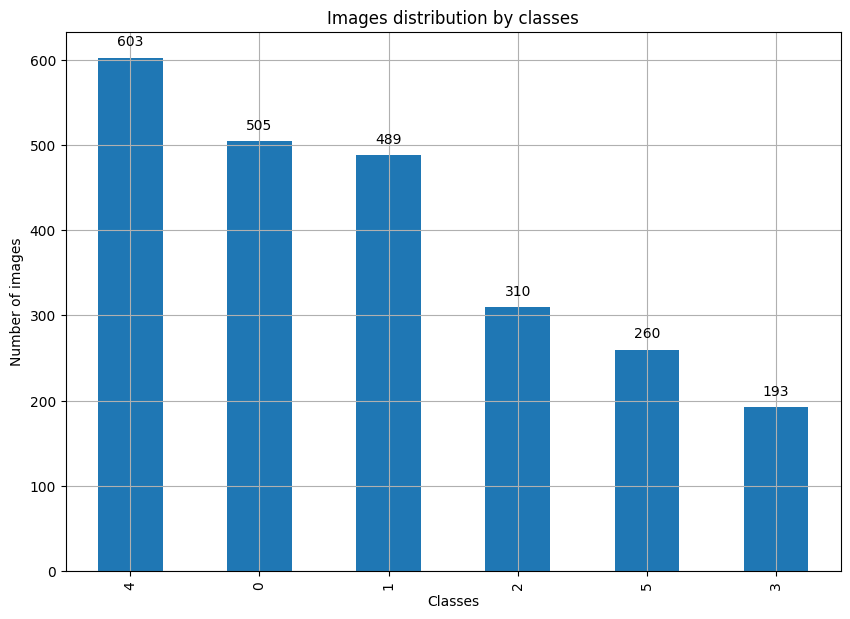

In [7]:
class_count = labels.class_6.astype ('int').value_counts()
ax = class_count.plot (kind = 'bar', figsize = (10,7), grid = True, title = 'Images distribution by classes' )
plt.xlabel ('Classes')
plt.ylabel ('Number of images')
for i, v in enumerate(class_count):
    ax.text(i, v + 10, str(v), ha='center', va='bottom')
plt.show()

The images distribution is **imbalanced**. The images with classes 0,1 and 4 are much more common than pictures of classes 2,5 and 3. Therefore, we shoud:

*   Use *F1-score* to evaluate the quality of the model
*   Use *stratification* for balancing model training



In [8]:
# downloading the images dataset and distribution into the training and validation dataset
image_dir = '/content/drive/MyDrive/images/images/train_images'
labels['class_6'] = labels['class_6'].astype(str)
# using the stratify for balancing datasets
train_df, val_df = train_test_split(labels, test_size=0.2, random_state=42, stratify=labels['class_6'])

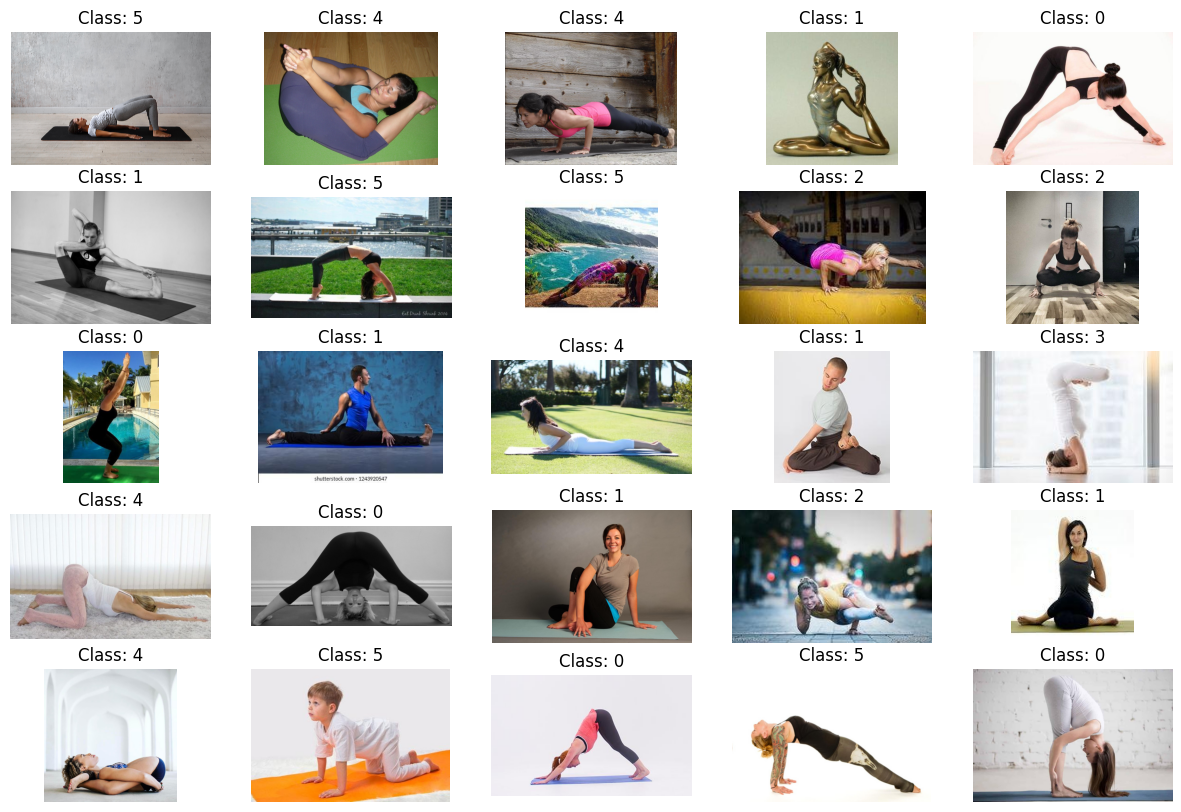

In [9]:
# The examples of dataset images
plt.figure(figsize=(15, 10))
for i in range(25):
    image_path = os.path.join(image_dir, labels['image_id'][i])
    image = Image.open(image_path)
    plt.subplot(5, 5, i + 1)
    plt.imshow(image)
    plt.title(f"Class: {labels['class_6'][i]}")
    plt.axis('off')
plt.show()

**Conclusion:** The images are not certified; there are many types and poses angles. That's why it's necessary to use augmentation.

<a name='Data_preprocessing'></a>
#**Data preprocessing**

The stages of preprocessing are:
1. Use Detectron2 to detirmine the body from background
2. Augementetion of the received image

###**1. Detectron2**

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

In [12]:
def segment_with_detectron2(image, predictor):
    outputs = predictor(image)
    r = outputs["instances"]
    if len(r.scores) == 0:
        # if no object, return the picture
        return image
    scores = [s if r.pred_classes[i] == 0 else 0 for i, s in enumerate(r.scores)]
    idx = r.scores.argmax()
    mask = r.pred_masks[idx,:,:].to('cpu')
    mask = np.stack((mask,)*3, axis=-1)
    mask = mask.astype('uint8')
    bg = 255 - mask * 255
    mask_img = image*mask
    segmented_image = mask_img + bg
    return segmented_image
def custom_preprocessing(image):
    segmented_image = segment_with_detectron2(image, predictor)
    return segmented_image

###**2. Augementetion**

In [ ]:
# Train generator
train_datagen = ImageDataGenerator (rescale = 1./255,
                                    rotation_range = 30,
                                    width_shift_range = 0.20,
                                    height_shift_range = 0.20,
                                    shear_range = 0.20,
                                    zoom_range = 0.3, #previous value 0.4
                                    horizontal_flip=True, # +++++
                                    fill_mode = 'nearest',
                                    preprocessing_function=custom_preprocessing )


train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='image_id',
    y_col='class_6',
    batch_size=128,
    shuffle=True,
    class_mode='categorical',
    target_size=(224, 224)  # Adjust the target size to the size of your input images
)
validation_datagen = ImageDataGenerator (rescale = 1./255, preprocessing_function=custom_preprocessing )
# Validation generator
val_generator = validation_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col='image_id',
    y_col='class_6',
    batch_size=128,
    shuffle=True,
    class_mode='categorical',
    target_size=(224, 224)
)

Found 1888 validated image filenames belonging to 6 classes.
Found 472 validated image filenames belonging to 6 classes.


### **3. The results of preprocessing images**

Training images

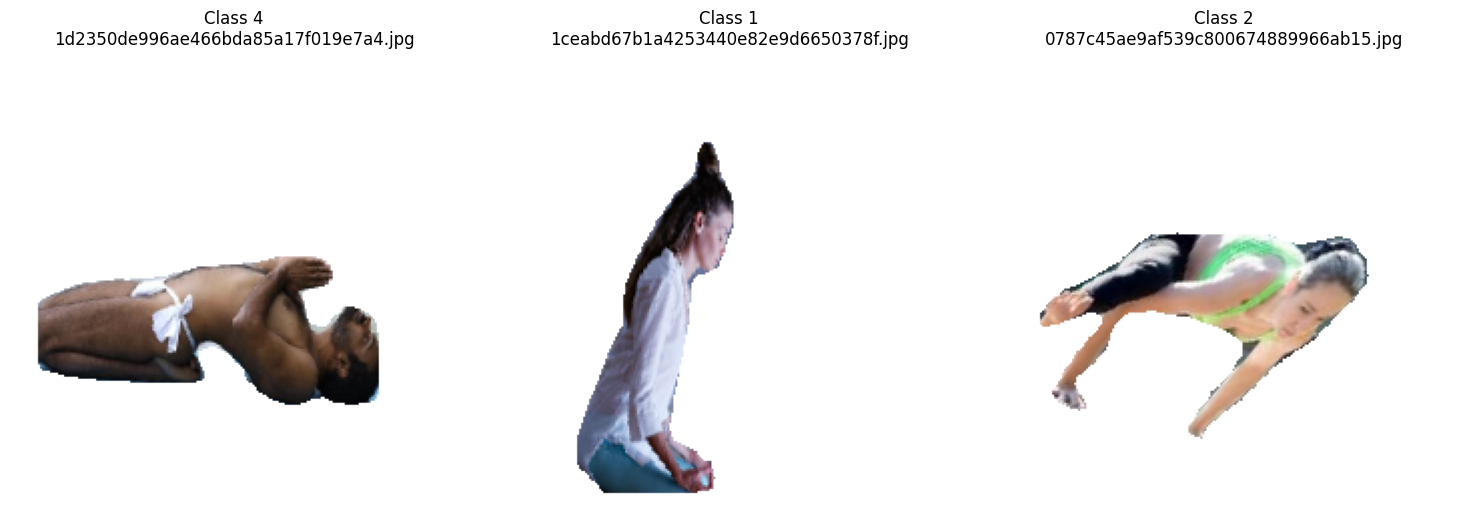

In [ ]:
batch_images, batch_labels = next(train_generator)
batch_filenames = train_generator.filenames[:3]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(batch_images[i])
    ax.axis('off')
    ax.set_title(f'Class {batch_labels[i].argmax()}\n{os.path.basename(batch_filenames[i])}')

plt.tight_layout()
plt.show()

Validation images

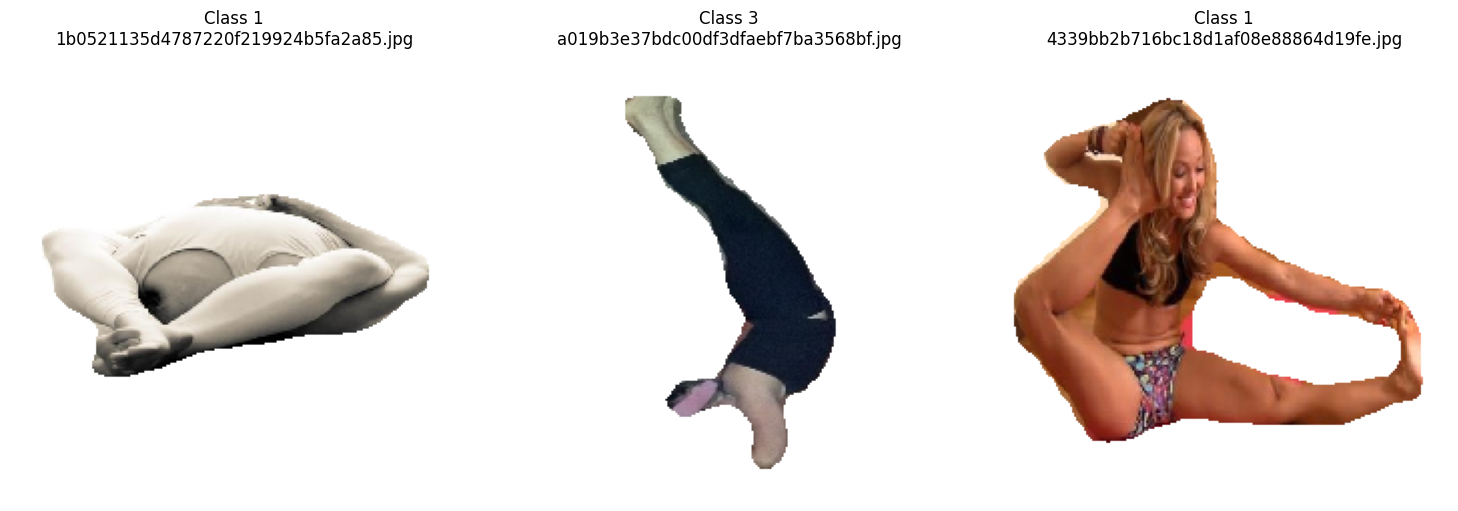

In [ ]:
batch_images, batch_labels = next(val_generator)
batch_filenames = val_generator.filenames[:3]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(batch_images[i])
    ax.axis('off')
    ax.set_title(f'Class {batch_labels[i].argmax()}\n{os.path.basename(batch_filenames[i])}')

plt.tight_layout()
plt.show()

**Conclusion:** The Detectron2 and Augmentation work correct. The images change in the right way

<a name='Model'></a>
#**Model**

The dataset is too small for training our own model (only 2360 images). Therefore, it's necessary to use pretrained models.
The idea of the model is to create an ensemble of models from EfficientNet, MobileNet_v3, ResNet, and DenseNet201.

In [13]:
# URL efficientnet
module_url_efficientnet = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
feature_extractor_efficientnet = hub.KerasLayer(module_url_efficientnet, trainable=False)
# URL mobilenet_v3
module_url_mobilenet_v3 = "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/classification/5"
feature_extractor_mobilenet_v3 = hub.KerasLayer(module_url_mobilenet_v3, trainable=False)
# URL ResNet 50
module_url = "https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/1"
feature_extractor_resnet = hub.KerasLayer(module_url, trainable=False)

In [16]:
def initialize_efficient_net_model(num_classes):
    input = tf.keras.layers.Input(shape=(224, 224, 3))
    x = feature_extractor_efficientnet(input)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.BatchNormalization() (x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dropout (0.4)(x)
    x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs=input, outputs=x)

def initialize_network__mobilenet_v3(num_classes):
    input = tf.keras.layers.Input(shape=(224, 224, 3))
    x = feature_extractor_mobilenet_v3(input)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(2048, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs=input, outputs=x)

def initialize_network_resnet(num_classes):
    input = tf.keras.layers.Input(shape=(224, 224, 3))
    x = feature_extractor_resnet(input)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(2048, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.4) (x)
    x = tf.keras.layers.BatchNormalization() (x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dropout (0.4) (x)
    x = tf.keras.layers.BatchNormalization() (x)
    x = tf.keras.layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
    return tf.keras.Model(inputs=input, outputs=x)

def initialize_network__DenseNet201(num_classes):
    base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(244,244,3))
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout (0.4) (x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization() (x)
    x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs=base_model.input, outputs=x)
    return model



### **Initializing the model**

In [ ]:
num_classes = 6

efficient_net_model = initialize_efficient_net_model(num_classes)
mobilenet_v3_net_model = initialize_network__mobilenet_v3(num_classes)
resnet_net_model = initialize_network_resnet(num_classes)
denseNet201_net_model = initialize_network__DenseNet201 (num_classes)

In [18]:
# f1-score function
def f1_score(y_true, y_pred):
    # Convert predictions to one-hot vectors
    y_pred = K.one_hot(K.argmax(y_pred), num_classes=6)

    # Calculate true positives, false positives, and false negatives over all classes
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    # Micro-average precision and recall
    micro_precision = K.sum(tp) / (K.sum(tp + fp) + K.epsilon())
    micro_recall = K.sum(tp) / (K.sum(tp + fn) + K.epsilon())

    # Calculate micro-averaged F1-score
    f1_score = 2 * micro_precision * micro_recall / (micro_precision + micro_recall + K.epsilon())
    return f1_score

### **Create ensemble of models**

In [ ]:
input = tf.keras.layers.Input(shape=(224, 224, 3))
outputs_efficient_net = efficient_net_model(input)
outputs_mobilenet_v3 = mobilenet_v3_net_model(input)
outputs_resnet_net_model = resnet_net_model(input)
outputs_denseNet201_net_model = denseNet201_net_model(input)

# Determine  weights for each models
weight_efficient_net = tf.keras.layers.Dense(1)(outputs_efficient_net)
weight_mobilenet_v3 = tf.keras.layers.Dense(1)(outputs_mobilenet_v3)
weight_resnet_net_model = tf.keras.layers.Dense(1)(outputs_resnet_net_model)
weight_denseNet201_net_model = tf.keras.layers.Dense(1)(outputs_denseNet201_net_model)

# Combine the weights into one vector
weights = tf.keras.layers.Concatenate()([weight_efficient_net, weight_mobilenet_v3, weight_resnet_net_model, weight_denseNet201_net_model])

# Use function of avtivation (softmax)
weights = tf.keras.layers.Activation('softmax')(weights)

# Multiply each model output by the corresponding weight
weighted_outputs_efficient_net = tf.keras.layers.Multiply()([weights[:, 0:1], outputs_efficient_net])
weighted_outputs_mobilenet_v3 = tf.keras.layers.Multiply()([weights[:, 1:2], outputs_mobilenet_v3])
weighted_outputs_resnet_net_model = tf.keras.layers.Multiply()([weights[:, 2:3], outputs_resnet_net_model])
weighted_outputs_denseNet201_net_model = tf.keras.layers.Multiply()([weights[:, 3:4], outputs_denseNet201_net_model])

# Add up weighted model outputs
ensemble_outputs = tf.keras.layers.Add()([weighted_outputs_efficient_net, weighted_outputs_mobilenet_v3, weighted_outputs_resnet_net_model, weighted_outputs_denseNet201_net_model])

ensemble_model = tf.keras.Model(inputs=input, outputs=ensemble_outputs)

In [ ]:
ensemble_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=f1_score)

<a name='Training'></a>
# **Training**

In [ ]:
# Tr = 0.6
history = ensemble_model.fit(train_generator,
                    epochs=60,
                    validation_data=val_generator, callbacks=[EarlyStopping(
              patience=10,
              min_delta=0.05,
              mode='max',
              monitor='val_f1_score',
              restore_best_weights=True,
              verbose=1)])

Epoch 1/60
15/15 [==============================] - 197s 13s/step - loss: 0.8352 - f1_score: 0.7160 - val_loss: 0.9185 - val_f1_score: 0.6820
Epoch 2/60
15/15 [==============================] - 184s 12s/step - loss: 0.8422 - f1_score: 0.7076 - val_loss: 0.8741 - val_f1_score: 0.6941
Epoch 3/60
15/15 [==============================] - 192s 13s/step - loss: 0.7990 - f1_score: 0.7224 - val_loss: 0.9369 - val_f1_score: 0.6861
Epoch 4/60
15/15 [==============================] - 183s 12s/step - loss: 0.8150 - f1_score: 0.7115 - val_loss: 1.0138 - val_f1_score: 0.6539
Epoch 5/60
15/15 [==============================] - 182s 12s/step - loss: 0.8114 - f1_score: 0.7220 - val_loss: 1.0000 - val_f1_score: 0.6552
Epoch 6/60
15/15 [==============================] - 192s 13s/step - loss: 0.8049 - f1_score: 0.7373 - val_loss: 0.9186 - val_f1_score: 0.6754
Epoch 7/60
15/15 [==============================] - 182s 12s/step - loss: 0.7650 - f1_score: 0.7401 - val_loss: 1.0086 - val_f1_score: 0.6648
Epoch 

**Conclusion:** The accuraccy of the model is 0.7

<a name='Prediction'></a>
# **Prediction**

In [ ]:
labels_test = pd.read_csv ('/content/drive/MyDrive/images/sample_submission.csv')
labels_test['class_6'] = labels['class_6'].astype(str)

In [ ]:
labels_test.head()

,image_id,class_6
0,18c514201d4d375596eaf057d43faa73.jpg,5
1,742cd45c52ee2d9a4745b27e1c5426a3.jpg,4
2,4ebf97acccead03c17d564c6701403ae.jpg,4
3,3a0fe12ec506d9fe99c0e370bce7eeef.jpg,1
4,d3442c050dd87db8b926b449408d793a.jpg,0


In [ ]:
test_dir = '/content/drive/MyDrive/images/images/test_images'

In [ ]:
test_datagen = ImageDataGenerator (rescale = 1./255, preprocessing_function=custom_preprocessing )
#test generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=labels_test,
    directory=test_dir,
    x_col='image_id',
    y_col='class_6',
    batch_size=128,
    shuffle=False,
    class_mode='categorical',
    target_size=(224, 224)
)

Found 756 validated image filenames belonging to 6 classes.


In [ ]:
predictions = ensemble_model.predict(test_generator)
predicted_labels = predictions.argmax(axis=1)

6/6 [==============================] - 56s 10s/step


In [ ]:
predicted_labels = predictions.argmax(axis=1)

In [ ]:
predicted_labels

array([5, 1, 1, 3, 0, 2, 1, 0, 5, 4, 1, 0, 1, 4, 4, 5, 0, 1, 1, 2, 1, 0,
       4, 5, 4, 0, 2, 2, 1, 2, 1, 3, 5, 0, 4, 4, 0, 2, 5, 2, 0, 4, 5, 0,
       2, 4, 4, 3, 0, 1, 4, 4, 4, 0, 3, 0, 0, 1, 4, 4, 1, 5, 1, 0, 2, 4,
       0, 3, 5, 1, 4, 0, 0, 0, 4, 1, 1, 2, 4, 1, 1, 3, 0, 2, 2, 0, 5, 0,
       1, 3, 4, 2, 0, 1, 4, 2, 0, 0, 1, 2, 5, 4, 0, 5, 5, 1, 0, 4, 0, 0,
       1, 2, 0, 4, 2, 5, 4, 1, 4, 2, 0, 4, 4, 0, 2, 1, 0, 0, 5, 0, 1, 4,
       0, 0, 0, 1, 5, 1, 0, 1, 4, 4, 1, 3, 1, 0, 0, 5, 5, 0, 3, 1, 0, 5,
       1, 4, 5, 2, 4, 4, 0, 3, 1, 1, 0, 2, 5, 1, 2, 1, 1, 1, 1, 1, 1, 4,
       0, 1, 1, 0, 0, 2, 1, 1, 1, 0, 5, 3, 2, 4, 0, 1, 4, 1, 3, 1, 4, 4,
       0, 1, 0, 1, 2, 4, 1, 0, 0, 1, 3, 1, 1, 2, 5, 2, 4, 1, 4, 5, 3, 0,
       3, 4, 3, 4, 1, 0, 1, 1, 1, 4, 1, 1, 3, 1, 5, 4, 1, 0, 2, 2, 4, 2,
       1, 2, 4, 5, 4, 4, 4, 0, 0, 4, 5, 5, 1, 4, 1, 4, 4, 0, 3, 0, 1, 5,
       4, 1, 1, 2, 4, 0, 0, 1, 1, 0, 5, 2, 2, 1, 0, 1, 4, 3, 1, 1, 5, 0,
       5, 1, 4, 1, 4, 1, 4, 4, 1, 0, 1, 4, 3, 4, 2,

In [ ]:
labels_test['class_6'] = predicted_labels

In [ ]:
labels_test.head()

,image_id,class_6
0,18c514201d4d375596eaf057d43faa73.jpg,5
1,742cd45c52ee2d9a4745b27e1c5426a3.jpg,1
2,4ebf97acccead03c17d564c6701403ae.jpg,1
3,3a0fe12ec506d9fe99c0e370bce7eeef.jpg,3
4,d3442c050dd87db8b926b449408d793a.jpg,0


In [ ]:
labels_test.to_csv('submission2.csv', index=False)

In [ ]:
files.download('submission2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>